In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/cedar/signatures/

Mounted at /content/drive
/content/drive/My Drive/cedar/signatures


In [12]:
from torch.optim import RMSprop, Adam
from torch.utils.data import DataLoader
import numpy as np
from torch import save
from torch import load
from torch.nn import Linear, Conv2d, MaxPool2d, LocalResponseNorm, Dropout
from torch.nn.functional import relu
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch import Tensor
import torchsummary
import torch

from sklearn.model_selection import train_test_split
import numpy as np

from PIL import Image
from PIL.ImageOps import invert
import pickle
from random import randrange

In [3]:
def invert_image_path(path):
    image_file = Image.open(path)  # open colour image
    image_file = image_file.convert('L').resize([220, 155])
    image_file = invert(image_file)
    image_array = np.array(image_file)
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            if image_array[i][j] <= 50:
                image_array[i][j] = 0
            else:
                image_array[i][j] = 255
    return image_array


def convert_to_image_tensor(image_array):
    image_array = image_array / 255.0
    return Tensor(image_array).view(1, 220, 155)


def show_inverted(path):
    img = Image.fromarray(invert_image_path(path))
    img.show()


def invert_image(image_file):
    image_file = image_file.convert('L').resize([220, 155])
    image_file = invert(image_file)
    image_array = np.array(image_file)
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            if image_array[i][j] <= 50:
                image_array[i][j] = 0
            else:
                image_array[i][j] = 255
    return image_array

In [4]:
base_path_org = 'signatures/full_org/original_%d_%d.png'
base_path_forg = 'signatures/full_forg/forgeries_%d_%d.png'

data = []
n_samples_of_each_class = 13500

for _ in range(n_samples_of_each_class):
    anchor_person = randrange(1, 55)
    # anchor_sign = randrange(1, 24)
    pos_sign = randrange(1, 24)
    # anchor_sign, pos_sign = fix_pair(anchor_sign, pos_sign)
    neg_sign = randrange(1, 24)

    positive = [base_path_org % (anchor_person, pos_sign), 1]
    negative = [base_path_forg % (anchor_person, neg_sign), 0]

    # positive = [base_path_org % (anchor_person, anchor_sign), base_path_org % (anchor_person, pos_sign), 1]
    # negative = [base_path_org % (anchor_person, anchor_sign), base_path_forg % (anchor_person, neg_sign), 0]
    data.append(positive)
    data.append(negative)

train, test = train_test_split(data, test_size=0.20)
with open('train_index_binary.pkl', 'wb') as train_index_file:
    pickle.dump(train, train_index_file)

with open('test_index_binary.pkl', 'wb') as test_index_file:
    pickle.dump(test, test_index_file)


class TrainDataset(Dataset):

    def __init__(self):
        with open('train_index_binary.pkl', 'rb') as train_index_file:
            self.pairs = pickle.load(train_index_file)

    def __getitem__(self, index):
        item = self.pairs[index]
        X = convert_to_image_tensor(invert_image_path(item[0]))
        # Y = convert_to_image_tensor(invert_image_path(item[1]))
        return [X, item[1]]

    def __len__(self):
        return len(self.pairs)


class TestDataset(Dataset):

    def __init__(self):
        with open('test_index_binary.pkl', 'rb') as test_index_file:
            self.pairs = pickle.load(test_index_file)

    def __getitem__(self, index):
        item = self.pairs[index]
        X = convert_to_image_tensor(invert_image_path(item[0]))
        # Y = convert_to_image_tensor(invert_image_path(item[1]))
        return [X, item[1]]

    def __len__(self):
        return len(self.pairs)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

nclasses = 128 # GTSRB has 43 classes
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(133760, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, nclasses),
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
    
        return F.log_softmax(x,dim=1) 


In [9]:
# import torchsummary
log_interval = 2
epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Net()
model.to(device)

# print(model)

# print(torchsummary.summary(model))

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

decayRate = 0.96
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

train_dataset = TrainDataset()
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True)

test_dataset = TestDataset()
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

def train(epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(data)
        # loss = F.nll_loss(output, target)
        # print(output.shape)
        # print(target.shape)
        loss = F.cross_entropy(output, target)
        # loss = torch.nn.BCEWithLogitsLoss()
        # loss = loss(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # loss = torch.nn.BCEWithLogitsLoss(reduction="sum")
        # loss = loss(output, target.unsqueeze(1).float())
        # validation_loss += loss.item() 
 
        validation_loss += F.cross_entropy(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


losses_list = []
for epoch in range(1, epochs + 1):
    losses_list.extend(train(epoch))
    validation()
    lr_scheduler.step()
    model_file = 'model_binary_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


cuda:0
Train Epoch: 1 [0/21600 (0%)]	Loss: 5.014287
Train Epoch: 1 [96/21600 (0%)]	Loss: 3.825138
Train Epoch: 1 [192/21600 (1%)]	Loss: 2.875783
Train Epoch: 1 [288/21600 (1%)]	Loss: 2.351973
Train Epoch: 1 [384/21600 (2%)]	Loss: 1.513813
Train Epoch: 1 [480/21600 (2%)]	Loss: 1.306931
Train Epoch: 1 [576/21600 (3%)]	Loss: 0.984637
Train Epoch: 1 [672/21600 (3%)]	Loss: 0.668337
Train Epoch: 1 [768/21600 (4%)]	Loss: 0.623043
Train Epoch: 1 [864/21600 (4%)]	Loss: 0.725847
Train Epoch: 1 [960/21600 (4%)]	Loss: 0.769949
Train Epoch: 1 [1056/21600 (5%)]	Loss: 0.691719
Train Epoch: 1 [1152/21600 (5%)]	Loss: 0.747567
Train Epoch: 1 [1248/21600 (6%)]	Loss: 0.411536
Train Epoch: 1 [1344/21600 (6%)]	Loss: 0.529067
Train Epoch: 1 [1440/21600 (7%)]	Loss: 0.458953
Train Epoch: 1 [1536/21600 (7%)]	Loss: 0.488704
Train Epoch: 1 [1632/21600 (8%)]	Loss: 0.401880
Train Epoch: 1 [1728/21600 (8%)]	Loss: 0.420006
Train Epoch: 1 [1824/21600 (8%)]	Loss: 0.272656
Train Epoch: 1 [1920/21600 (9%)]	Loss: 0.409668

In [11]:
model = Net()
print(model)

Net(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(


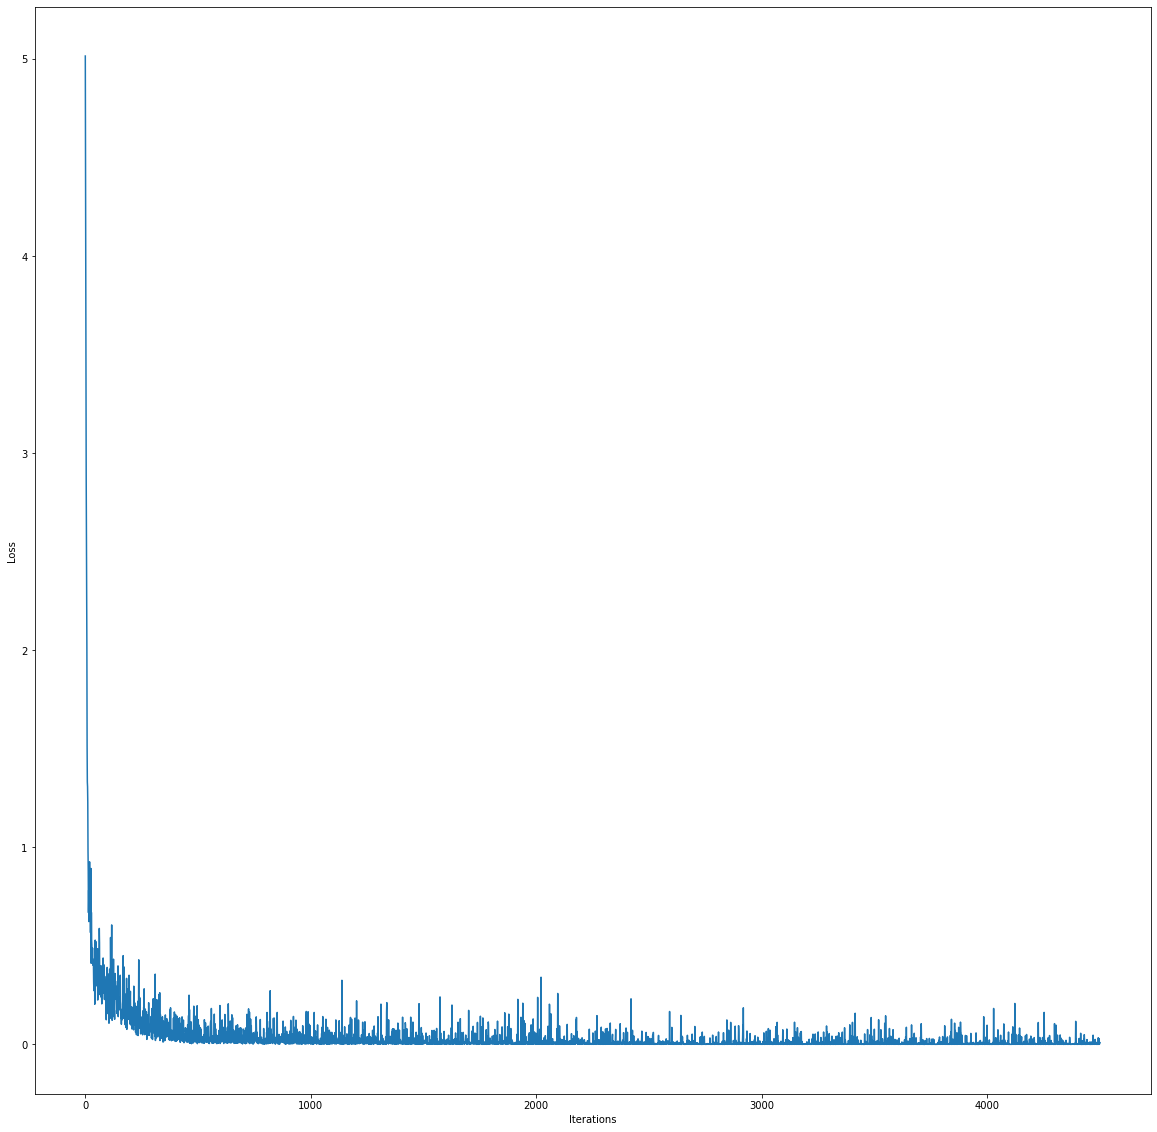

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 20]
plt.plot(losses_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()